In [50]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

#image
from skimage.transform import resize
from skimage.util import crop
import random
import numpy as np

#keras
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Add, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, ReLU, LeakyReLU, Conv2DTranspose, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#pip install -q -U tensorboard

In [51]:
#Hyperparameters
PATH = "./X-Ray_Disease_Classification-master/Data/Images/"
effusion_path = "./X-Ray_Disease_Classification-master/Data/test2.csv"
infiltration_path = "./X-Ray_Disease_Classification-master/Data/test4.csv"

BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

N_CLASSES = 2
CLASS_NAMES = [ 'Effusion', 'Infiltration']

# n_input = 200704
n_input = 25088

OUTPUT_CHANNELS = 2
EPOCHS = 150

In [54]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)
    
    input_image = tf.cast(image, tf.float32)
    input_image = input_image / 255.
    
    return input_image

(1024, 1024, 3)


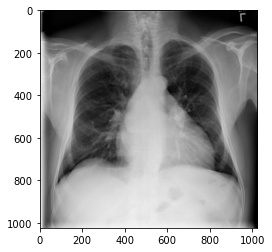

In [55]:
#test_load_image
inp= load(PATH+'00000001_000.png')
# casting to int for matplotlib to show the image
print(inp.shape)
plt.figure()
plt.imshow(inp)

In [56]:
#Preprocessing
def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image

def random_crop(input_image):

    cropped_image = tf.image.random_crop(input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def normalize(input_image):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    input_image = (input_image - imagenet_mean) / imagenet_std
    return input_image


@tf.function()
def random_jitter(input_image):
    input_image = resize(input_image, 254, 254) # resizing to 286 x 286 x 3

    input_image = random_crop(input_image) # randomly cropping to 256 x 256 x 3

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)

    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


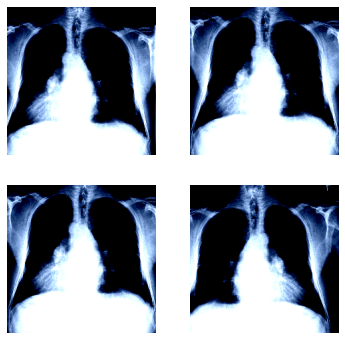

In [58]:
#test_jitter
"""
1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally
"""

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp = random_jitter(inp)
    rj_inp = normalize(rj_inp)
    out2 = rj_inp
    plt.subplot(2, 2, i+1)
    plt.imshow(out2)
    plt.axis('off')
plt.show()

In [59]:
def load_image_train(image_file):
    input_image = load(PATH+image_file)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image

def load_image_test(image_file):
    input_image = load(PATH+image_file)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    input_image = normalize(input_image)

    return input_image

In [60]:
def load_csv_train(image, label):
    input_image = load_image_train(image)

    return input_image, label

def load_csv_test(image, label):
    input_image = load_image_test(image)

    return input_image, label

#Input Pipeline
import pandas as pd
import numpy

num_lines_eff = sum(1 for l in open(effusion_path))
num_lines_inf = sum(1 for l in open(infiltration_path))
print(num_lines_eff)
print(num_lines_inf)

size_train = 3000
size_test = 100
skip_idx_train_eff = random.sample(range(1, num_lines_eff), num_lines_eff - size_train)
skip_idx_test_eff = random.sample(range(1, num_lines_eff), num_lines_eff - size_test)
skip_idx_train_inf = random.sample(range(1, num_lines_inf), num_lines_inf - size_train)
skip_idx_test_inf = random.sample(range(1, num_lines_inf), num_lines_inf - size_test)

eff_train = pd.read_csv(effusion_path, skiprows=skip_idx_train_eff, index_col=None, header = 0)
eff_test = pd.read_csv(effusion_path, skiprows=skip_idx_test_eff, index_col=None, header = 0)
inf_train = pd.read_csv(infiltration_path,  skiprows=skip_idx_train_inf, index_col=None, header = 0)
inf_test = pd.read_csv(infiltration_path,  skiprows=skip_idx_test_inf, index_col=None, header = 0)

train = []
train.append(eff_train)
train.append(inf_train)
train = pd.concat(train, axis=0, ignore_index=True)
from sklearn.utils import shuffle
train = shuffle(train)
image_train = train.pop('Image Index')
label_train = train.pop('Finding Labels')
print(image_train)
print(label_train)

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, label_train))
train_dataset = train_dataset.map(load_csv_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test = []
test.append(eff_test)
test.append(inf_test)
test = pd.concat(test, axis=0, ignore_index=True)
from sklearn.utils import shuffle
test = shuffle(test)
image_test = test.pop('Image Index')
label_test = test.pop('Finding Labels')
print(image_test)
print(label_test)

test_dataset = tf.data.Dataset.from_tensor_slices((image_test, label_test))
test_dataset = test_dataset.map(load_csv_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

3956
9548
4460    00016240_005.png
1880    00017137_009.png
3558    00006296_036.png
3106    00001183_000.png
5346    00023011_000.png
              ...       
1080    00010772_003.png
5551    00026072_002.png
4251    00013922_022.png
346     00003891_001.png
1224    00011814_022.png
Name: Image Index, Length: 5998, dtype: object
4460    1
1880    0
3558    1
3106    1
5346    1
       ..
1080    0
5551    1
4251    1
346     0
1224    0
Name: Finding Labels, Length: 5998, dtype: int64
155    00018523_003.png
187    00026925_003.png
106    00003432_003.png
103    00002000_006.png
109    00004581_004.png
             ...       
159    00018840_042.png
143    00014352_006.png
43     00012805_008.png
37     00010815_017.png
41     00012223_003.png
Name: Image Index, Length: 198, dtype: object
155    1
187    1
106    1
103    1
109    1
      ..
159    1
143    1
43     0
37     0
41     0
Name: Finding Labels, Length: 198, dtype: int64


In [62]:
#Build Model
def CNN_MODEL():
    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    
    x= inputs
    
    initializer = tf.random_normal_initializer(0., 0.02)

    model = Sequential()
    model.add(Conv2D(64, 4, strides=2, padding='valid', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 4, strides=2, padding='valid',
                                 kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, 4, strides=2, padding='valid',
                                 kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2))
    
    x=model(x)
    
    return Model(inputs=inputs, outputs = x)

In [63]:
CNN = CNN_MODEL()
CNN.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 931362    
Total params: 931,362
Trainable params: 930,466
Non-trainable params: 896
_________________________________________________________________


In [64]:
CNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = CNN.fit(train_dataset, epochs=10, 
                    validation_data=(test_dataset))

Epoch 1/10
188/188 [==============================] - 45s 239ms/step - loss: 0.6748 - accuracy: 0.6032 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
188/188 [==============================] - 43s 226ms/step - loss: 0.6367 - accuracy: 0.6289 - val_loss: 0.6406 - val_accuracy: 0.6465
Epoch 3/10
188/188 [==============================] - 37s 198ms/step - loss: 0.6288 - accuracy: 0.6372 - val_loss: 0.6365 - val_accuracy: 0.6313
Epoch 4/10
188/188 [==============================] - 39s 210ms/step - loss: 0.6309 - accuracy: 0.6354 - val_loss: 0.6258 - val_accuracy: 0.6465
Epoch 5/10
188/188 [==============================] - 44s 234ms/step - loss: 0.6236 - accuracy: 0.6437 - val_loss: 0.6641 - val_accuracy: 0.6212
Epoch 6/10
188/188 [==============================] - 45s 239ms/step - loss: 0.6130 - accuracy: 0.6531 - val_loss: 0.6395 - val_accuracy: 0.6414
Epoch 7/10
188/188 [==============================] - 46s 242ms/step - loss: 0.6116 - accuracy: 0.6546 - val_loss: 0.6193 

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [61]:
import keras

def DenseNet_MODEL():
    img_input = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    base_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],
        weights="imagenet",
        pooling="avg")
    
    x = base_model.output
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)
    return Model(inputs=img_input, outputs=predictions)

model = DenseNet_MODEL()
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, 
                    validation_data=(test_dataset))

Epoch 1/10
188/188 [==============================] - 101s 539ms/step - loss: 0.2001 - accuracy: 0.7091 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
188/188 [==============================] - 90s 479ms/step - loss: 0.1752 - accuracy: 0.7402 - val_loss: 0.1715 - val_accuracy: 0.7626
Epoch 3/10
188/188 [==============================] - 88s 470ms/step - loss: 0.1670 - accuracy: 0.7558 - val_loss: 0.1994 - val_accuracy: 0.7525
Epoch 4/10
188/188 [==============================] - 89s 473ms/step - loss: 0.1655 - accuracy: 0.7604 - val_loss: 0.1780 - val_accuracy: 0.8081
Epoch 5/10
188/188 [==============================] - 90s 481ms/step - loss: 0.1582 - accuracy: 0.7756 - val_loss: 0.1975 - val_accuracy: 0.7374
Epoch 6/10
188/188 [==============================] - 90s 481ms/step - loss: 0.1534 - accuracy: 0.7766 - val_loss: 0.2165 - val_accuracy: 0.7374
Epoch 7/10
188/188 [==============================] - 91s 485ms/step - loss: 0.1514 - accuracy: 0.7819 - val_loss: 0.2407

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')